In [614]:
from netgen.meshing import *
from ngsolve import *
from netgen.meshing import Mesh as NGMesh
from ngsolve.webgui import Draw
from netgen.geom2d import SplineGeometry, unit_square
import matplotlib.pyplot as plt
import numpy as np
import pickle
from ngsolve import CoefficientFunction

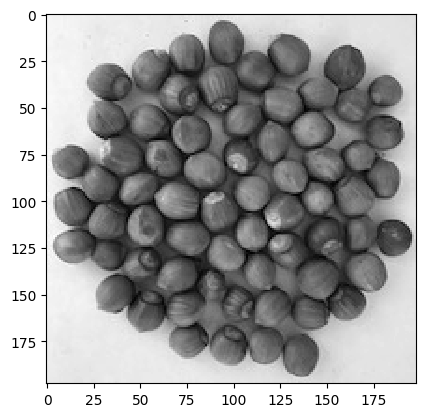

In [615]:
with open('img.pkl','rb') as fp:
    img = pickle.load(fp)
plt.imshow(img,interpolation='none', cmap='gray')


In [616]:
# Define the number of elements in each direction
nx = int((img.shape[0]-1)/1)
ny = int((img.shape[1]-1)/1)

# Create a SplineGeometry object
geom = SplineGeometry()

# Add points to the geometry
p1 = geom.AppendPoint(0, 0)
p2 = geom.AppendPoint(1, 0)
p3 = geom.AppendPoint(1, 1)
p4 = geom.AppendPoint(0, 1)

# Add lines to the geometry
geom.Append(["line", p1, p2], bc="bottom")
geom.Append(["line", p2, p3], bc="right")
geom.Append(["line", p3, p4], bc="top")
geom.Append(["line", p4, p1], bc="left")

# Generate the mesh
mesh = Mesh(geom.GenerateMesh(maxh=1.0/min(nx, ny)))


In [617]:
Draw(mesh)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

BaseWebGuiScene

In [618]:
# Init Parameter:
t0 = 0
dt0 = 0.1
tend = 3
eps0 = 1e-4
d2t = 0.02  #Änderungsrate für dt

# parameter initialization
t = Parameter (t0)
dt = Parameter (dt0)
eps = Parameter (eps0)

In [619]:
# FEM Raum => Annahme Order = 2
V = H1(mesh, order=2)

# Trial Funktion
u = V.TrialFunction()
# Test Funktion 
v = V.TestFunction()

gfu = GridFunction(V)

a = BilinearForm (V, symmetric = False)
a += Variation((eps/2*grad(u)*grad(u) 
               +(u**2*(1-u*u)**2)
               + 0.5/dt*(u-gfu)**2)*dx)

In [620]:
a.AssembleLinearization(gfu.vec)

In [621]:
img_array = np.array(img)
print(img_array.shape)
print(img_array)

(198, 198)
[[0.9161449  0.9161449  0.90608515 ... 0.74423073 0.73417098 0.73417098]
 [0.92620466 0.9161449  0.90608515 ... 0.74423073 0.74423073 0.73417098]
 [0.92620466 0.9161449  0.9161449  ... 0.75429049 0.74423073 0.74423073]
 ...
 [0.83066616 0.83066616 0.8206064  ... 0.74854435 0.74854435 0.7384846 ]
 [0.83066616 0.83066616 0.8206064  ... 0.74854435 0.7384846  0.7384846 ]
 [0.83066616 0.8206064  0.8206064  ... 0.7384846  0.7384846  0.7384846 ]]


In [622]:
print(img_array[100, 100])
print(np.min(img_array))    # check if the image is normalized from -1 to 1
print(np.max(img_array))

-0.655624408989397
-1.0
1.0


Das Bild enthält Werte zwischen -1 und 1, das ist ideal für unsere Anwendung. Wir werden deshalb nichts normalisieren müssen.

In [623]:
u0 = img_array

In [624]:
cfImg = VoxelCoefficient((0,0),(1,1),
                         img[np.arange(img.shape[0]-1,-1,-1)])
Draw(cfImg,mesh,'cfImg')

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

BaseWebGuiScene

In [625]:
# Convert numpy array to list
u0_list = u0.tolist()

# Create CoefficientFunction from list
u0_cf = CoefficientFunction(u0_list)

# Now you can set the GridFunction
#gfu.Set(u0_cf)
gfu.Set(cfImg)

In [626]:
res = gfu.vec.CreateVector()
du = gfu.vec.CreateVector()

In [627]:
InnerProduct(du,res)

nan

In [628]:
# Convert GridFunction to numpy array
gfu_array = gfu.vec.FV().NumPy()

gfu_array_t0 = gfu_array.copy()

# Print the minimum and maximum values of the GridFunction
print(np.min(gfu_array), np.max(gfu_array))

-2.6514588030539104 3.683734796378884


In [629]:
# Newton Verfahren:
for it in range(100000):
    print("Newton iteration", it)

    # solve linearized problem:
    # F(u_n)
    a.Apply (gfu.vec, res)

    # F'(u_n)
    a.AssembleLinearization(gfu.vec)
    # TODO: Alternativ die selber berechnete variation (a1) verwenden mit:
    #a1.Assemble()

    du.data = a.mat.Inverse(V.FreeDofs()) * res
    # TODO: alternativ selber berechnete variation verwenden mit:
    #du.data = a1.mat.Inverse(V.FreeDofs()) * res

    # update interation
    # u_n+1 = u_n - du
    gfu.vec.data -= du

    # change value of eps based on time passed
    eps.Set(eps.Get() * 1e-2)
    print("eps:", eps.Get())

    # Aktuelle Zeit updaten
    t.Set(t.Get()+dt.Get())
    print("Seconds passed: ", t.Get())

    #stop after 2 seconds
    t += dt.Get()
    print(t)
    if t >= tend:
        break

    # dt für nächsten Schritt updaten
    dt.Set(dt.Get() + d2t)
    print("dt für nächste Iteration: ", dt.Get())
    

Newton iteration 0
eps: 1.0000000000000002e-06
Seconds passed:  0.1
ParameterCF, val = 0.2

dt für nächste Iteration:  0.12000000000000001
Newton iteration 1
eps: 1.0000000000000002e-08
Seconds passed:  0.32
ParameterCF, val = 0.44

dt für nächste Iteration:  0.14
Newton iteration 2
eps: 1.0000000000000002e-10
Seconds passed:  0.5800000000000001
ParameterCF, val = 0.72

dt für nächste Iteration:  0.16
Newton iteration 3
eps: 1.0000000000000002e-12
Seconds passed:  0.8800000000000001
ParameterCF, val = 1.04

dt für nächste Iteration:  0.18
Newton iteration 4
eps: 1.0000000000000002e-14
Seconds passed:  1.22
ParameterCF, val = 1.4

dt für nächste Iteration:  0.19999999999999998
Newton iteration 5
eps: 1.0000000000000002e-16
Seconds passed:  1.5999999999999999
ParameterCF, val = 1.8

dt für nächste Iteration:  0.21999999999999997
Newton iteration 6
eps: 1.0000000000000003e-18
Seconds passed:  2.0199999999999996
ParameterCF, val = 2.24

dt für nächste Iteration:  0.23999999999999996
Newton

In [630]:
Draw(gfu)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

BaseWebGuiScene

In [631]:
# Convert GridFunction to numpy array
gfu_array_2s = gfu.vec.FV().NumPy()

# Print the minimum and maximum values of the GridFunction
print(np.min(gfu_array_2s), np.max(gfu_array_2s))

-5.573876619738105 9.054677562123501


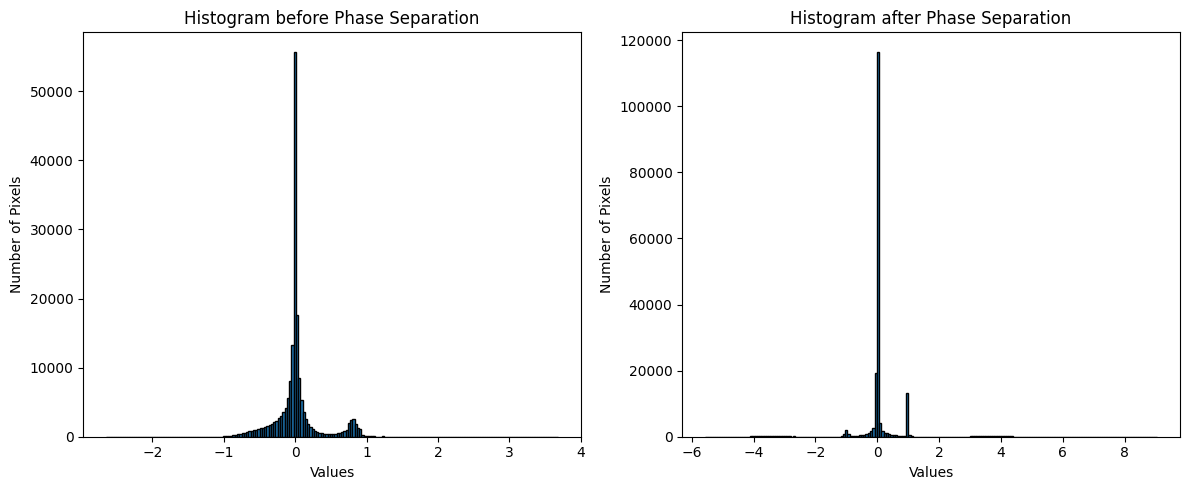

In [632]:
# Set a higher resolution for bins
num_bins = 200

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot the first histogram
axs[0].hist(gfu_array_t0, bins=num_bins, edgecolor='black')
#axs[0].set_yscale('log')  # Set y-axis scale to logarithmic
axs[0].set_title('Histogram before Phase Separation')
axs[0].set_xlabel('Values')
axs[0].set_ylabel('Number of Pixels')

# Plot the second histogram
axs[1].hist(gfu_array_2s, bins=num_bins, edgecolor='black')
#axs[1].set_yscale('log')  # Set y-axis scale to logarithmic
axs[1].set_title('Histogram after Phase Separation')
axs[1].set_xlabel('Values')
axs[1].set_ylabel('Number of Pixels')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

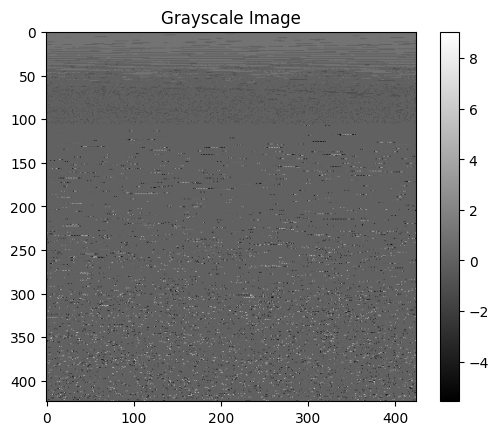

In [633]:
size = int(np.sqrt(len(gfu_array_2s)))
gfu_array_2s_reshaped = gfu_array_2s[:size**2].reshape((size, size))

plt.imshow(gfu_array_2s_reshaped, cmap='gray')
plt.colorbar()  # Optionally, you can add a colorbar to show intensity values
plt.title('Grayscale Image')
plt.show()